In [34]:
from img_classify.dataset import *
from img_classify.downloader import *
from img_classify.evaluate_model import *
from img_classify.tools import *
from keras import Sequential
from keras.applications import *
from keras.callbacks import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import AdamW
from keras.src.utils import set_random_seed

In [35]:
# Tải dữ liệu từ thư viện Kaggle
if not os.path.exists('datasets/tyre_quality'):
	kaggle_downloader(
		'tyre_quality',
		'warcoder/tyre-quality-classification'
	)

In [36]:
# Thiết lập chung
train_path = 'datasets/tyre_quality/Digital images of defective and good condition tyres/'
img_save_path = 'imgs/tyre_quality/'
set_random_seed(69)
IMG_SIZE = (128, 128, 3)

In [37]:
# Tạo nhãn cho tập dữ liệu
class_names = create_label_from_dir(train_path).output

=> Your label are: ['defective', 'good']


In [38]:
# Kiểm tra ảnh trong thư mục
check_dir(train_path)

=> Have 2 subdirectories & 0 files in datasets/tyre_quality/Digital images of defective and good condition tyres/
=> Have 0 subdirectories & 1028 files in datasets/tyre_quality/Digital images of defective and good condition tyres/defective
=> Have 0 subdirectories & 1020 files in datasets/tyre_quality/Digital images of defective and good condition tyres/good


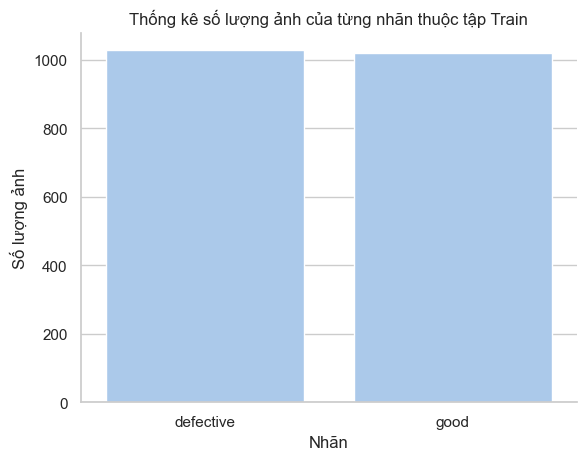

== MỨC CHÊNH LỆCH GIỮA CÁC NHÃN TẬP TRAIN SO VỚI NHÃN CAO NHẤT==
Nhãn defective: 100.0
Nhãn good: 99.222


In [39]:
# Kiểm tra độ cân bằng dữ liệu
check_balance(
	train_path,
	class_names,
	img_save_path=os.path.join(img_save_path, 'check_balance.jpg')
)


Loại trừ nhãn defective do đã cân bằng !
Loại trừ nhãn good do đã cân bằng !


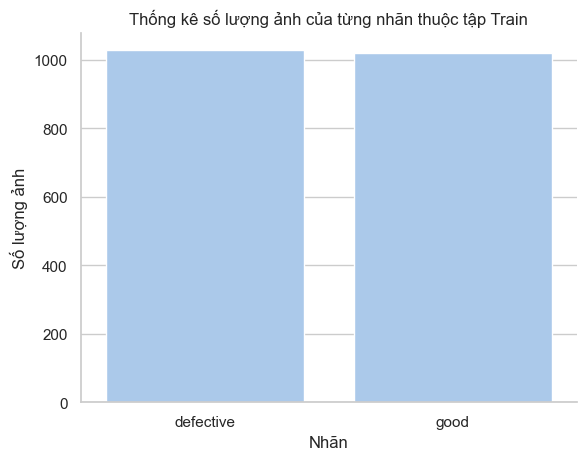

== MỨC CHÊNH LỆCH GIỮA CÁC NHÃN TẬP TRAIN SO VỚI NHÃN CAO NHẤT==
Nhãn defective: 100.0
Nhãn good: 99.222


In [40]:
# Tái cân bằng tập dữ liệu
img_model = ImageDataGenerator(
	horizontal_flip=True,
	vertical_flip=True,
	width_shift_range=.2,
	height_shift_range=.2,
	zoom_range=.2
)

fix_imbalance_with_image_augmentation(
	train_path,
	img_model=img_model,
	img_size=(IMG_SIZE[0], IMG_SIZE[1]),
	class_names=class_names
)

== Thống kê số lượng ảnh sau khi tách ==
Train: 1361 ảnh
Test: 512 ảnh
Val: 72 ảnh
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                     

D:\Python\image_classification\venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


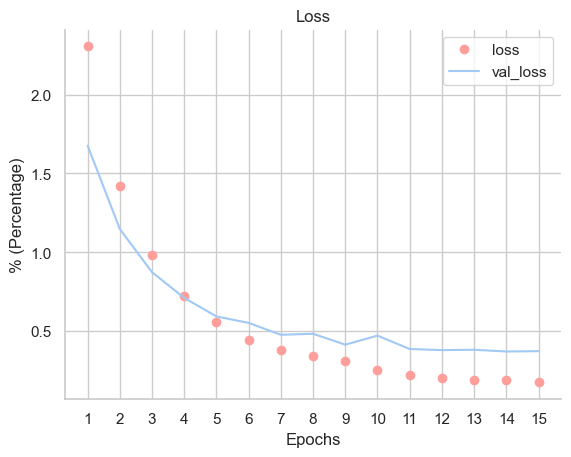

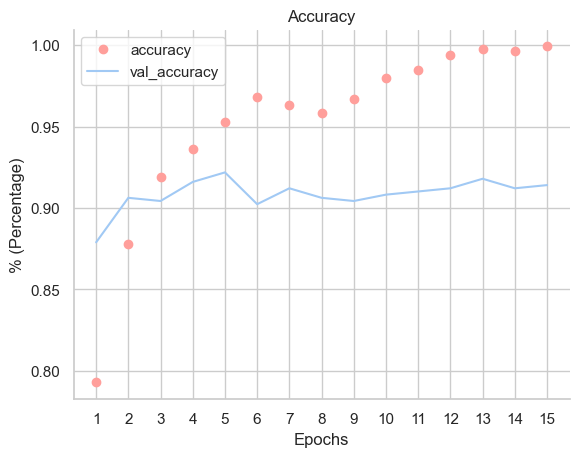

In [41]:
## Nạp ảnh
a = images_to_array(train_path, class_names, (IMG_SIZE[0], IMG_SIZE[1]))
images, labels = a.images, a.labels

## Tách mảng để Train/Test/Val (65/20/15)
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = train_test_val_split(
	images,
	labels,
	train_size=.70,
	test_size=.25,
	val_size=.05
).output

## Tăng cường ảnh tập Train
train_img_model = ImageDataGenerator(
	horizontal_flip=True,
	vertical_flip=True,
	zoom_range=.2,
	rotation_range=30,
	shear_range=.2
)
train_img_model.flow(
	train_images,
	train_labels,
	seed=69
)

## Rescale ảnh
train_images = train_images / 255.
test_images = test_images / 255.
val_images = val_images / 255.

# Xây dựng mô hình
def my_model():
	#  Thiết lập mô hình
	base_model = MobileNetV2(include_top=False, input_shape=IMG_SIZE)
	base_model.trainable = False
	model = Sequential(
		[
			base_model,

			GlobalAveragePooling2D(),
			Flatten(),
			Dense(128, activation='relu', kernel_regularizer='l2'),
			Dropout(.2),
			Dense(64, activation='relu'),
			Dropout(.2),
			Dense(len(class_names), activation='softmax')
		]
	)
	# Biên dịch mô hình
	model.compile(
		AdamW(),
		CategoricalCrossentropy(),
		['accuracy']
	)
	return model

# Chọn mô hình
model = my_model()
# Khái quát mô hình
model.summary()
# Đào tạo mô hình
history = model.fit(
	train_images,
	train_labels,
	epochs=100,
	validation_data=(test_images, test_labels),
	callbacks=[
		EarlyStopping(
			monitor='val_accuracy',
			patience=10,
			restore_best_weights=True
		),
		ReduceLROnPlateau(
			monitor='val_accuracy',
			factor=.1,
			patience=5,
			min_lr=.0001
		)
	]
)
# Lưu mô hình
model.save('models/tyre_quality_model.h5')
# Đánh giá quá trình đào tạo
EvalofTraining(history, img_save_path)



16/16 [==============================] - 6s 363ms/step - loss: 0.5938 - accuracy: 0.9219
Sai số: 0.5938005447387695
Độ chính xác: 0.921875
3/3 [==============================] - 4s 297ms/step


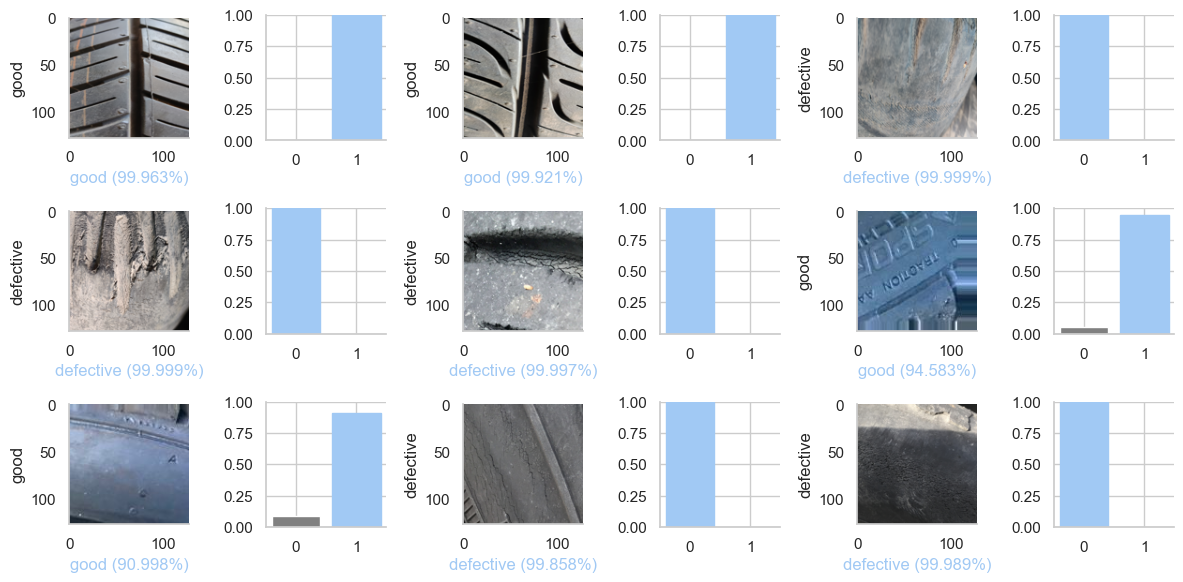

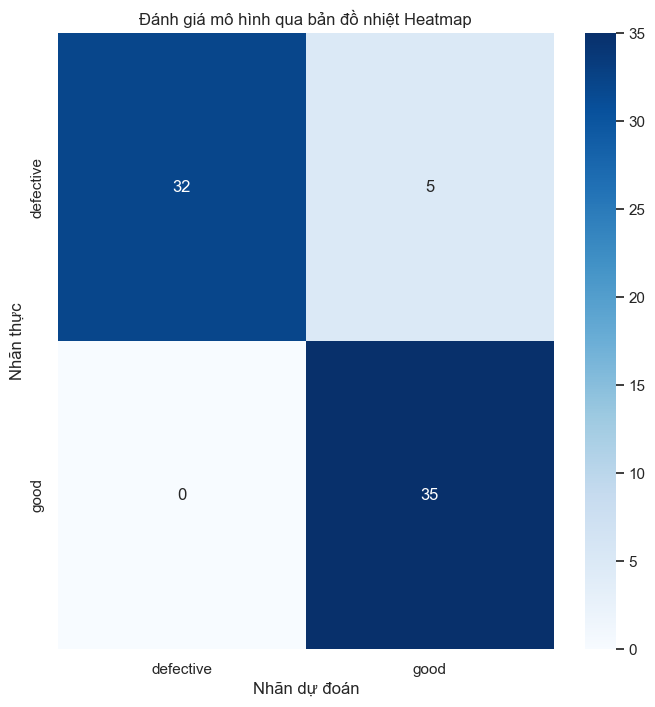

In [42]:
# Đánh giá mô hình
## Đánh giá mô hình qua tập Test
sai_so, do_chinh_xac = model.evaluate(test_images, test_labels)
print(f'Sai số: {sai_so}')
print(f'Độ chính xác: {do_chinh_xac}')
## Dự đoán 6 ảnh trong tập Val
pred_labels = model.predict(val_images)
eval_of_model_with_images(
	3, 3, val_images, pred_labels, val_labels, class_names,
	img_save_path=os.path.join(img_save_path, 'eval_of_model_with_images.jpg')
)
## Đánh giá mô hình bằng biểu đồ nhiệt
heatmap_plot(
	val_labels,
	pred_labels,
	class_names,
	img_save_path=os.path.join(img_save_path, 'eval_of_model_with_heatmap.jpg')
)